<a href="https://colab.research.google.com/github/GorokhovSemyon/TextClassification/blob/main/PEFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка необходимых библиотек

In [ ]:
!pip install evaluate numpy torch tensorboard datasets tqdm transformers wandb clearml

## Подключение необходимых библиотек

In [2]:
import evaluate
import numpy as np
import torch
from datasets import DatasetDict
from datasets import load_dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import get_scheduler
from transformers import Trainer, TrainerCallback
from transformers import TrainingArguments
from torch.utils.tensorboard import SummaryWriter
from clearml import Task

# Гиперпараметры

In [3]:
BATCH_SIZE = 64
LR = 1e-4
LR_TYPE = 'cosine'  # 'linear', 'constant'
N_EPOCHS = 5
WARMUP_STEPS = 20

## Инициализация ClearML

In [ ]:
# Инициализация задачи ClearML
task = Task.init(project_name='PEFT', task_name='LoRA', tags=['Model:prajjwal1/bert-tiny', 'type:notebook'])

In [6]:
# Логирование гиперпараметров
task.connect({'BATCH_SIZE': BATCH_SIZE, 'LR': LR, 'LR_TYPE': LR_TYPE, 'N_EPOCHS': N_EPOCHS, 'WARMUP_STEPS': WARMUP_STEPS})

{'BATCH_SIZE': 64,
 'LR': 0.0001,
 'LR_TYPE': 'cosine',
 'N_EPOCHS': 5,
 'WARMUP_STEPS': 20}

2024-08-10 13:49:09,485 - clearml.Task - INFO - Storing jupyter notebook directly as code


In [7]:
# Создание логгера
logger = task.get_logger()

# Загрузка датасета yelp_review_full

In [8]:
ds = load_dataset("yelp_review_full")


ds = DatasetDict({
    'train': ds['train'].shuffle(seed=1).select(range(5000)),
    'test': ds['test'].shuffle(seed=1).select(range(500)),
})

task.upload_artifact(name="ds.train", artifact_object=ds['train'])
task.upload_artifact(name="ds.test", artifact_object=ds['test'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

True

# Токенизация датасета

In [9]:
model_id = 'prajjwal1/bert-tiny'

tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,
    )

tokenized_ds = ds.map(tokenize_function, batched=True)

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

# Полное обучение

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=5)

training_args = TrainingArguments(
    output_dir='output',
    learning_rate=LR,
    lr_scheduler_type=LR_TYPE,
    warmup_steps=WARMUP_STEPS,
    num_train_epochs=N_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',  # где будем хранить логи
    logging_steps=10,  # логировать каждые 10 шагов
)

metric_accuracy = evaluate.load("accuracy")
metric_recall = evaluate.load("recall")
metric_precision = evaluate.load("precision")
metric_f1 = evaluate.load("f1")

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

2024-07-27 17:34:07,997 - clearml.model - INFO - Selected model id: 09257a9f938048be84686e6c41b13b90


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



In [ ]:
from clearml import Task, Logger

EXPERIMENT_NUM = 2

def log_metrics_to_clearml(logger, experiment_num, accuracy, recall, precision, f1):
    logger.report_scalar("Accuracy", "Accuracy", accuracy, iteration=experiment_num)
    logger.report_scalar("Recall", "Recall", recall, iteration=experiment_num)
    logger.report_scalar("Precision", "Precision", precision, iteration=experiment_num)
    logger.report_scalar("F1", "F1", f1, iteration=experiment_num)



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)
    recall = metric_recall.compute(predictions=predictions, references=labels, average='macro')
    precision = metric_precision.compute(predictions=predictions, references=labels, average='macro')
    f1 = metric_f1.compute(predictions=predictions, references=labels, average='macro')

    print(accuracy, recall, precision, f1)

    log_metrics_to_clearml(logger, EXPERIMENT_NUM, accuracy['accuracy'], recall['recall'], precision['precision'], f1['f1'])

    return {**accuracy, **recall, **precision, **f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['test'],
    compute_metrics=compute_metrics
)

trainer.train()


2024-07-27 18:14:03,452 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers_7/accelerator_config[AcceleratorConfig])


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.578900,1.400970,0.470000,0.462848,0.470988,0.465550
2,0.894700,1.417235,0.484000,0.473083,0.463201,0.464919
3,0.744400,1.424464,0.478000,0.469432,0.478551,0.471807
4,0.702900,1.424954,0.468000,0.462117,0.466073,0.462690
5,0.664500,1.431764,0.470000,0.462671,0.471278,0.465417


{'accuracy': 0.47} {'recall': 0.4628478064191023} {'precision': 0.4709882182190729} {'f1': 0.46555024719252025}
{'accuracy': 0.484} {'recall': 0.4730826711411611} {'precision': 0.46320078596089287} {'f1': 0.4649186263563923}
{'accuracy': 0.478} {'recall': 0.4694321880200354} {'precision': 0.4785513644423018} {'f1': 0.47180667817085126}
{'accuracy': 0.468} {'recall': 0.4621173094672607} {'precision': 0.4660733629614834} {'f1': 0.4626900550429962}
{'accuracy': 0.47} {'recall': 0.4626712572811452} {'precision': 0.4712779156327544} {'f1': 0.4654171174546161}


TrainOutput(global_step=395, training_loss=0.7101397278942639, metrics={'train_runtime': 425.3653, 'train_samples_per_second': 58.773, 'train_steps_per_second': 0.929, 'total_flos': 7947974400000.0, 'train_loss': 0.7101397278942639, 'epoch': 5.0})

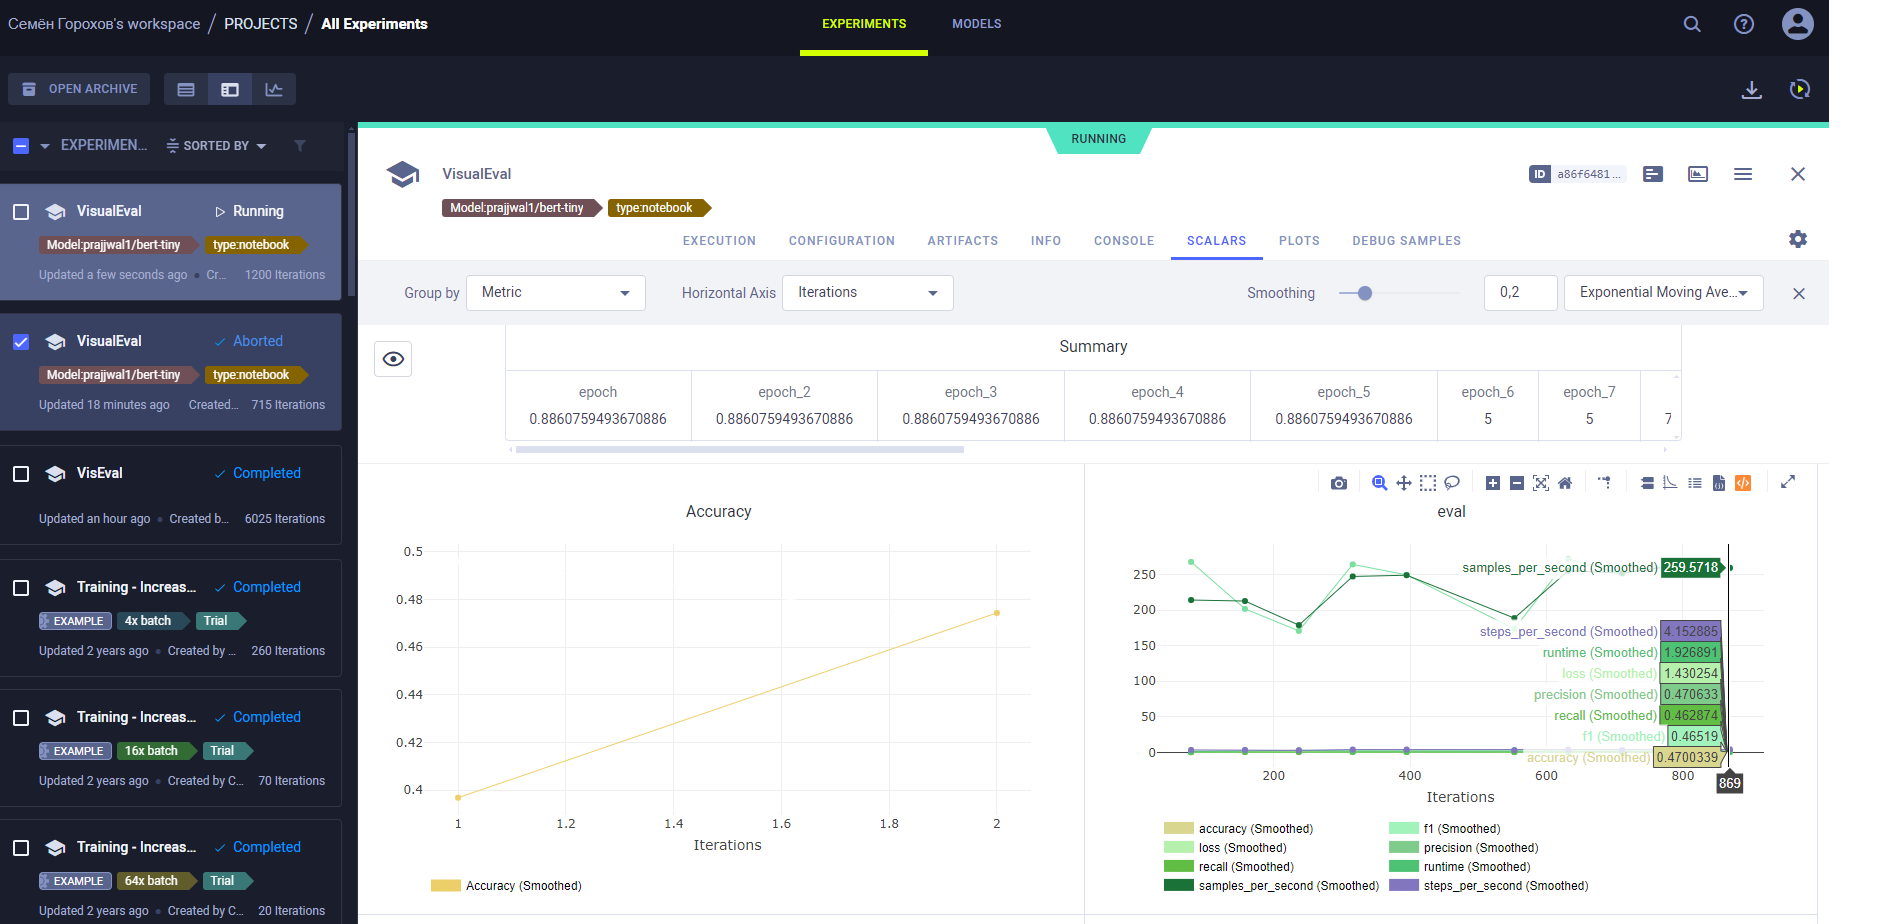

# Обучение с помощью PEFT


In [ ]:
!pip install peft

In [13]:
from peft import get_peft_model, LoraConfig, TaskType

In [21]:
peft_config = LoraConfig(
    r=16, lora_alpha=32, lora_dropout=0.1, bias="none", task_type="SEQ_CLS"
)

In [22]:
def print_number_of_trainable_model_parameters(model):
    '''
    Pull out the number of model parameters and find out how many of them are trainable.
    '''
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"


In [23]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=5)
peft_model = get_peft_model(model, peft_config)

print(print_number_of_trainable_model_parameters(peft_model))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable model parameters: 17029
all model parameters: 4403594
percentage of trainable model parameters: 0.39%


In [24]:
training_args = TrainingArguments(
    output_dir='output',
    learning_rate=LR,
    lr_scheduler_type=LR_TYPE,
    warmup_steps=WARMUP_STEPS,
    num_train_epochs=N_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',  # где будем хранить логи
    logging_steps=10,  # логировать каждые 10 шагов
)

metric_accuracy = evaluate.load("accuracy")
metric_recall = evaluate.load("recall")
metric_precision = evaluate.load("precision")
metric_f1 = evaluate.load("f1")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



In [25]:
from clearml import Task, Logger

EXPERIMENT_NUM = 1

def log_metrics_to_clearml(logger, experiment_num, accuracy, recall, precision, f1):
    logger.report_scalar("Accuracy", "Accuracy", accuracy, iteration=experiment_num)
    logger.report_scalar("Recall", "Recall", recall, iteration=experiment_num)
    logger.report_scalar("Precision", "Precision", precision, iteration=experiment_num)
    logger.report_scalar("F1", "F1", f1, iteration=experiment_num)



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)
    recall = metric_recall.compute(predictions=predictions, references=labels, average='macro')
    precision = metric_precision.compute(predictions=predictions, references=labels, average='macro')
    f1 = metric_f1.compute(predictions=predictions, references=labels, average='macro')

    print(accuracy, recall, precision, f1)

    log_metrics_to_clearml(logger, EXPERIMENT_NUM, accuracy['accuracy'], recall['recall'], precision['precision'], f1['f1'])

    return {**accuracy, **recall, **precision, **f1}

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['test'],
    compute_metrics=compute_metrics
)

trainer.train()


2024-08-10 14:05:27,419 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers_2/accelerator_config[AcceleratorConfig])


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,1.612300,1.603579,0.194000,0.205914,0.330221,0.158180
2,1.592500,1.583835,0.280000,0.278647,0.314293,0.256451
3,1.579700,1.570942,0.280000,0.275903,0.302875,0.236097
4,1.574800,1.564551,0.302000,0.295195,0.323861,0.254079
5,1.564900,1.563471,0.308000,0.300967,0.327559,0.255567


{'accuracy': 0.194} {'recall': 0.20591424917946277} {'precision': 0.33022088353413653} {'f1': 0.15818042137120242}
2024-08-10 14:06:21,697 - clearml.frameworks - INFO - Found existing registered model id=255015827629475c8cc49e89a4081932 [/content/output/checkpoint-79/training_args.bin] reusing it.
2024-08-10 14:06:25,695 - clearml.frameworks - INFO - Found existing registered model id=8a38bcd8a7f04768817856d18515e7d4 [/content/output/checkpoint-79/optimizer.pt] reusing it.
2024-08-10 14:06:29,549 - clearml.frameworks - INFO - Found existing registered model id=45427fa69bb5455d8315b98449160506 [/content/output/checkpoint-79/scheduler.pt] reusing it.
2024-08-10 14:06:33,412 - clearml.frameworks - INFO - Found existing registered model id=aa495a57677d4d9286ecd59f727ec81a [/content/output/checkpoint-79/rng_state.pth] reusing it.
{'accuracy': 0.28} {'recall': 0.2786473295406264} {'precision': 0.3142930575382964} {'f1': 0.2564514804408436}
2024-08-10 14:07:29,142 - clearml.frameworks - INFO 

TrainOutput(global_step=395, training_loss=1.5881958080243461, metrics={'train_runtime': 348.6824, 'train_samples_per_second': 71.698, 'train_steps_per_second': 1.133, 'total_flos': 8274931200000.0, 'train_loss': 1.5881958080243461, 'epoch': 5.0})

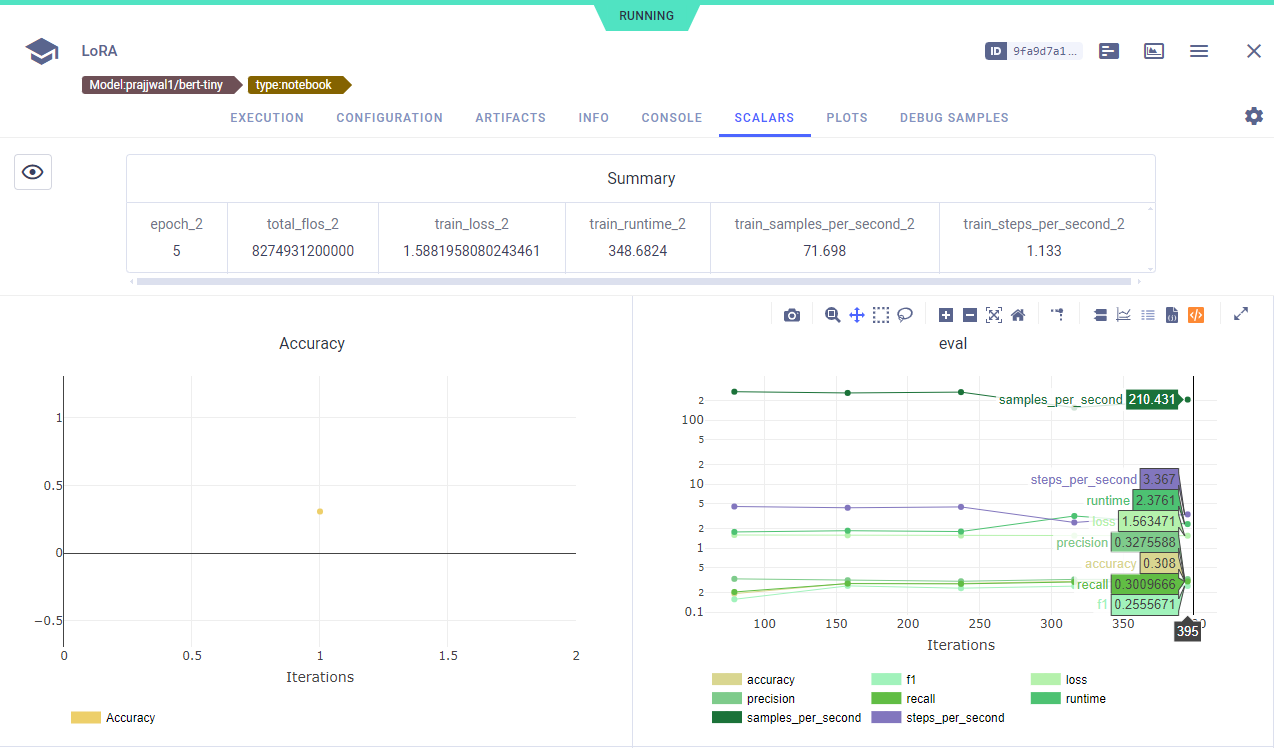

# Вывод

Библиотека "peft" представляет собой ценный инструмент для проведения файн-тюнинга моделей, обеспечивая возможность эффективного дообучения и адаптации моделей для конкретных задач. Особенно важна возможность использования LoRA для обучения больших моделей, поскольку это позволяет значительно экономить вычислительные ресурсы. В определенных ситуациях использование LoRA может быть единственной возможностью для успешного дообучения моделей на новых данных или задачах.

Сравнительный анализ результатов показывает, что полный файн-тюнинг моделей все же продемонстрирует лучшие показатели в определенных задачах. Тем не менее, следует отметить, что LoRA представляет собой мощный и эффективный инструмент, способный значительно улучшить процесс дообучения моделей. Этот метод может быть особенно полезен при работе с LLM и в условиях ограниченных ресурсов, так как LoRA способен оптимизировать процесс обучения и достичь высоких результатов при минимальных затратах. Расчетливое сочетание LoRA с другими методами peft может привести к оптимальным результатам и эффективному использованию имеющихся вычислительных возможностей.